In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import joblib

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

import rs_learn as rsl
import warnings

import warnings
warnings.filterwarnings("ignore")


#==============================================================#
# rs_learn: A library for applying machine learning processes  #
# and artificial neural network in Remote Sensing              #
#==============================================================#

#=====================================================================#
# Author:      Reginald Jay L. Argamosa <regi.argamosa@gmail.com>     #  
# Affiliation: University of the Philippines -                        #
#              Training Center for Applied Geodesy and Photogrammetry #
#=====================================================================#



In [2]:
# load data
df_main = pd.read_csv('all_data_raw.csv')
# df_main = pd.read_csv('few.csv')
#slice x and y
X = df_main.iloc[:,2:]
y = df_main['chl_a']
#slice train and test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [3]:
X.head(5)

,blue,green,red,re_1,re_2,re_3,re_4,swir_1,swir_2
0,1017,1198,815,1022,769,784,681,427,399
1,1216,1318,947,1053,814,828,709,474,419
2,1101,1274,910,893,459,479,337,173,142
3,1017,1183,772,725,308,326,186,48,32
4,825,1163,594,1092,691,713,502,197,161


In [4]:
#create new features
def create_features(X):
    X['G_over_R'] = X['green'] / X['red'] #G/R
    X['G_over_B'] = X['green'] / X['blue'] #G/B
    X['B_over_R'] = X['blue'] / X['red'] #B/R
    
    X['B_over_NIR_plus_G'] = (X['blue'] / X['re_1']) + X['green'] #B/NIR+G 
    
    X['SABI'] = (X['re_1'] - X['red']) / (X['blue'] + X['green'])
    
    X['kab1'] = (1.67-3.94)*np.log(X['blue'])+3.78*np.log(X['green'])
    X['NDWI'] = (X['green'] - X['re_1']) / (X['green'] + X['re_1']) 
    X['MNDWI'] = (X['green'] - X['swir_2']) / (X['green'] + X['swir_2'])
    X['NDMI'] = (X['red'] - X['re_1']) / (X['red'] + X['re_1'])
    
    X['NDCI'] = (X['re_1'] - X['red']) / (X['re_1'] + X['red']) 
    X['CHL1'] = X['re_2'] / (X['re_1'] - X['red'])
    
    # fill na those divided by zero
    X.replace([np.inf, -np.inf], 0, inplace = True)
    
    #show pca svd graph
    rsl.make_pca_svd_graph(X, 'features')
    
    #transform pca and svd
    df_pca, df_svd = rsl.transform_pca_svd(X,
                                           'll_features',
                                           n_pca = X.shape[1],
                                           n_svd = X.shape[1])
    #merge reference df 
    df_X = pd.concat([X, df_pca, df_svd], axis = 1)
    
    #binarize each columns
    for i in df_X.columns:
        df_X['%s_bin'%i] = rsl.binarize(df_X, i)
        
    return df_X

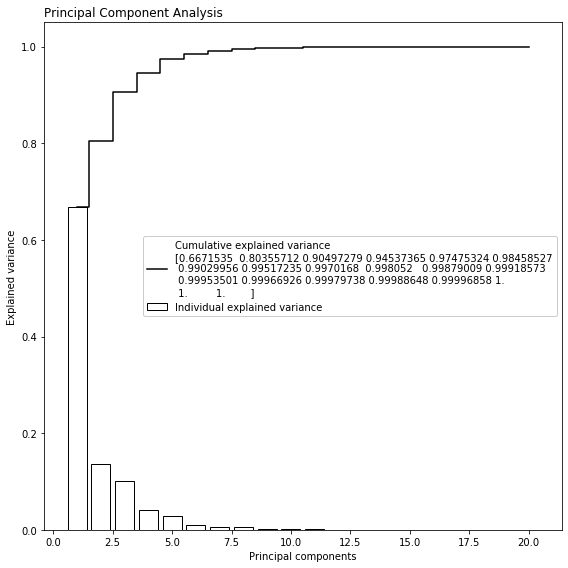

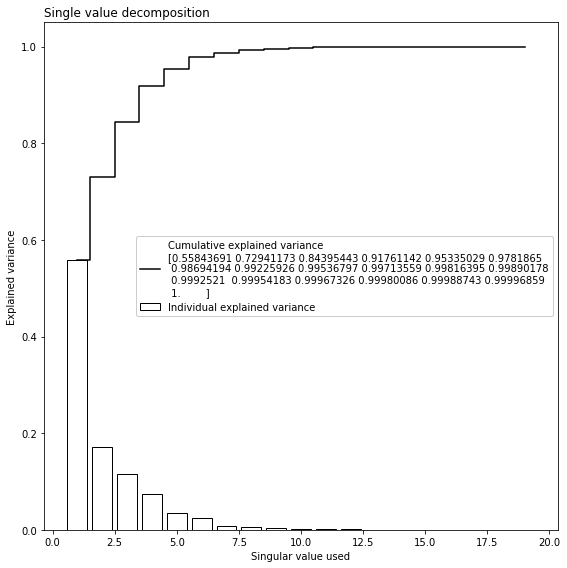


    Done transforming data into principal components
    and single values.
Binarization done for blue
Binarization done for green
Binarization done for red
Binarization done for re_1
Binarization done for re_2
Binarization done for re_3
Binarization done for re_4
Binarization done for swir_1
Binarization done for swir_2
Binarization done for G_over_R
Binarization done for G_over_B
Binarization done for B_over_R
Binarization done for B_over_NIR_plus_G
Binarization done for SABI
Binarization done for kab1
Binarization done for NDWI
Binarization done for MNDWI
Binarization done for NDMI
Binarization done for NDCI
Binarization done for CHL1
Binarization done for PC1
Binarization done for PC2
Binarization done for PC3
Binarization done for PC4
Binarization done for PC5
Binarization done for PC6
Binarization done for PC7
Binarization done for PC8
Binarization done for PC9
Binarization done for PC10
Binarization done for PC11
Binarization done for PC12
Binarization done for PC13
Binarizatio

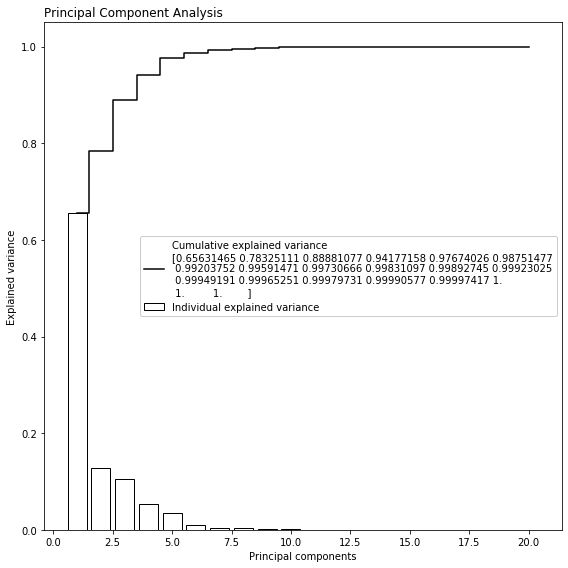

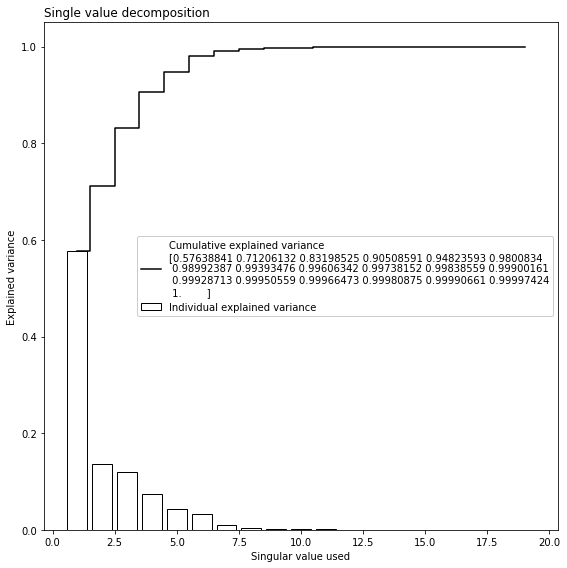


    Done transforming data into principal components
    and single values.
Binarization done for blue
Binarization done for green
Binarization done for red
Binarization done for re_1
Binarization done for re_2
Binarization done for re_3
Binarization done for re_4
Binarization done for swir_1
Binarization done for swir_2
Binarization done for G_over_R
Binarization done for G_over_B
Binarization done for B_over_R
Binarization done for B_over_NIR_plus_G
Binarization done for SABI
Binarization done for kab1
Binarization done for NDWI
Binarization done for MNDWI
Binarization done for NDMI
Binarization done for NDCI
Binarization done for CHL1
Binarization done for PC1
Binarization done for PC2
Binarization done for PC3
Binarization done for PC4
Binarization done for PC5
Binarization done for PC6
Binarization done for PC7
Binarization done for PC8
Binarization done for PC9
Binarization done for PC10
Binarization done for PC11
Binarization done for PC12
Binarization done for PC13
Binarizatio

In [5]:
df_X_train = create_features(X_train)
df_X_test = create_features(X_test)

In [6]:
df_X_train.head(3)

,blue,green,red,re_1,re_2,re_3,re_4,swir_1,swir_2,G_over_R,...,SVD10_bin,SVD11_bin,SVD12_bin,SVD13_bin,SVD14_bin,SVD15_bin,SVD16_bin,SVD17_bin,SVD18_bin,SVD19_bin
3737,1133,1468,1137,1193,659,709,538,398,367,1.291117,...,0,1,0,0,0,1,1,0,0,0
421,1036,1203,1060,1101,833,798,778,467,431,1.134906,...,0,1,0,1,0,1,0,0,1,0
1765,1081,1354,1059,1130,607,637,482,369,323,1.278565,...,0,1,0,0,0,1,1,0,0,0


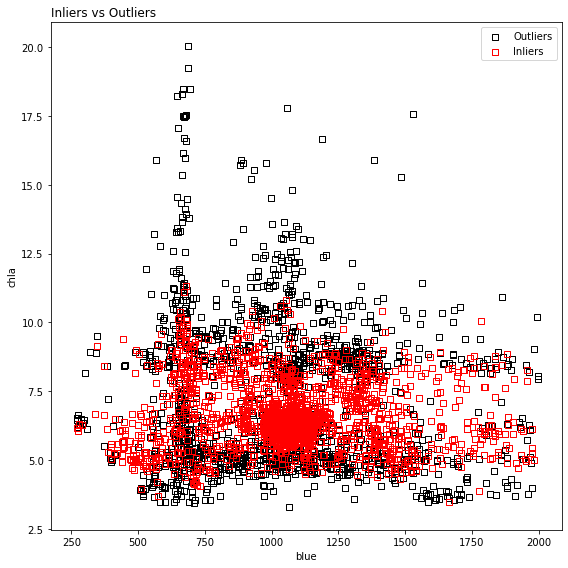

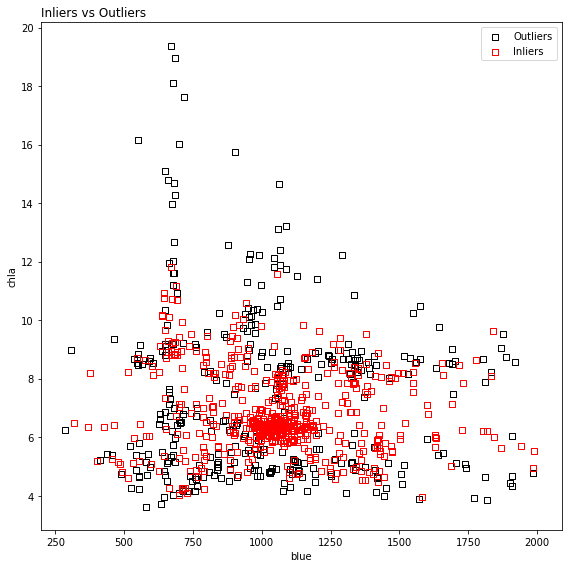

In [7]:
#remove outliers for train and test data
df_inliers_train, df_outliers_train = rsl.remove_outliers(df_X_train, 
                                              y_train, max_trials = 100,
                                              min_samples = df_X_train.shape[0],
                                              x_cols = 'blue', 
                                              xlabel = 'blue',
                                              ylabel = 'chla', 
                                              file_name = 'train',
                                              save_csv = False)

df_inliers_test, df_outliers_test = rsl.remove_outliers(df_X_test, 
                                              y_test, max_trials = 100,
                                              min_samples = df_X_test.shape[0],
                                              x_cols = 'blue', 
                                              xlabel = 'blue',
                                              ylabel = 'chla', 
                                              file_name = 'test',
                                              save_csv = False)

In [8]:
#slice inlier dataframes as x and y
X_train = df_inliers_train.iloc[:,:-1]
y_train = df_inliers_train['chl_a']

X_test = df_inliers_test.iloc[:,:-1]
y_test = df_inliers_test['chl_a']

In [9]:
print('original n rows: %s'%df_main.shape[0])
print('new n rows: %s'%X_train.shape[0])

original n rows: 4442
new n rows: 2027


In [10]:
#auto select important features and its values
X_train_final = rsl.select_features(X_train,
                               y_train,
                               RandomForestRegressor(n_estimators = 1000,
                                                     n_jobs = -1))
#get important features
feature_imp = X_train_final.columns

#save to csv
X_train_final.to_csv('X_train_final.csv',
                  index = False)

#select and use the important features
X_test_final = X_test[feature_imp]

#save to csv
X_test_final.to_csv('X_test_final.csv',
                    index = False)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	118
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	50
Tentative: 	6
Rejected: 	62
Iteration: 	9 / 100
Confirmed: 	50
Tentative: 	6
Rejected: 	62
Iteration: 	10 / 100
Confirmed: 	50
Tentative: 	6
Rejected: 	62
Iteration: 	11 / 100
Confirmed: 	50
Tentative: 	6
Rejected: 	62
Iteration: 	12 / 100
Confirmed: 	52
Tentative: 	4
Rejected: 	62
Iteration: 	13 / 100
Confirmed: 	52
Tentative: 	4
Rejected: 	62
Iteration: 	14 / 100
Confirmed: 	52
Tentative: 	4
Rejected: 	62
Iteration: 	15 / 100
Confirmed: 	52
Tentative: 	4
Rejected: 	62
Iteration: 	16 / 100
Confirmed: 	52
Tentative: 	4

In [11]:
#print important features
feature_imp

Index(['blue', 'red', 're_1', 're_2', 're_3', 'swir_1', 'swir_2', 'G_over_R',
       'G_over_B', 'B_over_R', 'B_over_NIR_plus_G', 'SABI', 'kab1', 'NDWI',
       'MNDWI', 'NDMI', 'NDCI', 'CHL1', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5',
       'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14',
       'PC15', 'PC16', 'PC17', 'PC18', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5',
       'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10', 'SVD11', 'SVD12', 'SVD13',
       'SVD14', 'SVD15', 'SVD16', 'SVD17', 'SVD19'],
      dtype='object')

In [12]:
print('original number of features: %s'%len(X_train.columns))
print('new number of features: %s'%len(feature_imp))

original number of features: 118
new number of features: 54


# #=========== train ensemble ===========# # 

In [13]:
#list of regressors to be used
key_list = ['lgb',
    'xgb',
    'cat',
    'rf',
    'dt',
    'svr',
    'knn',
    'lss',
    'enet',
    'rdg',
    'lr']

model_list = [
    LGBMRegressor(n_estimators = 1000),
    XGBRegressor(n_estimators = 300,
                            n_jobs = -1,
                            objective='reg:squarederror'),
    CatBoostRegressor(silent = True),                                
    RandomForestRegressor(n_estimators = 500,
                                    n_jobs = -1),
    DecisionTreeRegressor(),
    SVR(), 
    KNeighborsRegressor(n_jobs = -1),
    Lasso(max_iter = 20000),
    ElasticNet(max_iter = 20000),
    Ridge(),
    LinearRegression()
]

In [14]:
#level 1 of ensemble
prediction_train_l1 = rsl.train_ensemble(X_train_final,
                   y_train,
                   key_list,
                   model_list,
                   'level_1',
                   os.getcwd(),
                   folds = 10,
                   n_iteration = 3,
                   scoring = 'r2')


Number of iterations 0
Model lgb:
Scores mean kfold: 0.7137019374690813
Scores per fold: [0.75734169 0.71036645 0.70462851 0.66761108 0.73763591 0.67764231
 0.7241797  0.74356072 0.63472334 0.77932968]

Number of iterations 0
Model xgb:
Scores mean kfold: 0.7135469061147093
Scores per fold: [0.73427202 0.70903417 0.67624363 0.7204442  0.74487716 0.66445804
 0.69309482 0.78122755 0.67030205 0.74151541]

Number of iterations 0
Model cat:
Scores mean kfold: 0.7184351221896107
Scores per fold: [0.7343835  0.75734821 0.69350172 0.72483666 0.73299006 0.70051435
 0.69459141 0.73967909 0.69510923 0.71139699]

Number of iterations 0
Model rf:
Scores mean kfold: 0.6793048946599469
Scores per fold: [0.67793063 0.68222966 0.68209517 0.66039988 0.71569157 0.69122131
 0.65351027 0.66717503 0.67693778 0.68585765]

Number of iterations 0
Model dt:
Scores mean kfold: 0.36933802274681715
Scores per fold: [0.36499326 0.37124336 0.39651948 0.39493778 0.37455958 0.39646953
 0.38065535 0.47607197 0.3303720

In [15]:
#select important features from prediction_train_l1
prediction_train_l2 = rsl.select_features(prediction_train_l1,
                                  y_train,
                                  RandomForestRegressor(n_estimators = 1000))

important_feat_l2 = prediction_train_l2.columns


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	9
Rejected: 	18
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	9
Rejected: 	18
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	9
Rejected: 	18
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	9
Rejected: 	18
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	19
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	19
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	19
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	19
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	19
I

In [16]:
#print important features of to be used for level 2
important_feat_l2

Index(['level_1_0_lgb', 'level_1_0_cat', 'level_1_0_dt', 'level_1_1_lgb',
       'level_1_1_cat', 'level_1_1_dt', 'level_1_2_lgb', 'level_1_2_cat',
       'level_1_2_dt'],
      dtype='object')

In [17]:
print('original number of features: %s'%len(prediction_train_l1.columns))
print('new number of features: %s'%len(important_feat_l2))

original number of features: 33
new number of features: 9


In [18]:
#level 2 of ensemble
prediction_train_l2 = rsl.train_ensemble(prediction_train_l2,
                   y_train,
                   key_list,
                   model_list,
                   'level_2',
                   os.getcwd(),
                   folds = 10,
                   n_iteration = 2,
                   scoring = 'r2')


Number of iterations 0
Model lgb:
Scores mean kfold: 0.9979966656460958
Scores per fold: [0.99916622 0.99669435 0.99936288 0.99854611 0.99820259 0.99865481
 0.99532392 0.99885504 0.99549245 0.99966829]

Number of iterations 0
Model xgb:
Scores mean kfold: 0.9998106736602053
Scores per fold: [0.99991082 0.99988771 0.99957718 0.99978781 0.99990292 0.99988831
 0.9999089  0.99958052 0.99987762 0.99978494]

Number of iterations 0
Model cat:
Scores mean kfold: 0.9992273373686322
Scores per fold: [0.99891355 0.99802813 0.99926113 0.99964142 0.99909097 0.99829886
 0.99982956 0.99986315 0.99977725 0.99956934]

Number of iterations 0
Model rf:
Scores mean kfold: 0.9998802202421674
Scores per fold: [0.99999365 0.99962331 0.99998126 0.99999045 0.99999037 0.99995972
 0.99982283 0.99954272 0.99997761 0.99992028]

Number of iterations 0
Model dt:
Scores mean kfold: 0.999859693115585
Scores per fold: [0.9997944  0.99979252 0.99981646 0.99998984 0.99984814 0.99994026
 0.99993216 0.99953022 0.99996614 

In [19]:
#level 3, use simple regression
lr = LinearRegression()
lr.fit(prediction_train_l2,
       y_train)

joblib.dump(lr,
            os.path.join(os.getcwd(),
                         'output_rs_learn',
                         'misc',
                         'level_3_lr.sav'))

with open(os.path.join(os.getcwd(),
                       'acc_level_3_lr.txt'),'w') as t:   
    
    result = 'Scores level 3: %.4f'%lr.score(prediction_train_l2, 
                                             y_train)
    t.write(result)
    t.close()
print(result)

Scores level 3: 1.0000


# #=========== apply to test ===========# # 

In [20]:
import rs_learn as rsl

In [21]:
feature_imp

Index(['blue', 'red', 're_1', 're_2', 're_3', 'swir_1', 'swir_2', 'G_over_R',
       'G_over_B', 'B_over_R', 'B_over_NIR_plus_G', 'SABI', 'kab1', 'NDWI',
       'MNDWI', 'NDMI', 'NDCI', 'CHL1', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5',
       'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14',
       'PC15', 'PC16', 'PC17', 'PC18', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5',
       'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10', 'SVD11', 'SVD12', 'SVD13',
       'SVD14', 'SVD15', 'SVD16', 'SVD17', 'SVD19'],
      dtype='object')

In [22]:
X_test_final.columns

Index(['blue', 'red', 're_1', 're_2', 're_3', 'swir_1', 'swir_2', 'G_over_R',
       'G_over_B', 'B_over_R', 'B_over_NIR_plus_G', 'SABI', 'kab1', 'NDWI',
       'MNDWI', 'NDMI', 'NDCI', 'CHL1', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5',
       'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14',
       'PC15', 'PC16', 'PC17', 'PC18', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5',
       'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10', 'SVD11', 'SVD12', 'SVD13',
       'SVD14', 'SVD15', 'SVD16', 'SVD17', 'SVD19'],
      dtype='object')

In [23]:
#level 1
#important features determined from training level 1 will be used
prediction_test_l1 = rsl.reuse_model(X_test_final, 
                                y_test,'level_1',
                                    ws = os.getcwd())


r: 0.79, r2: 0.62, rmse: 0.89
r: 0.42, r2: 0.17, rmse: 1.40
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.78, r2: 0.61, rmse: 0.87
r: 0.76, r2: 0.58, rmse: 0.90
r: -0.09, r2: 0.01, rmse: 22759376340335.89
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.56, r2: 0.31, rmse: 1.15
r: 0.75, r2: 0.56, rmse: 0.94
r: 0.50, r2: 0.25, rmse: 1.29
r: 0.76, r2: 0.57, rmse: 0.91
r: 0.79, r2: 0.62, rmse: 0.89
r: 0.44, r2: 0.20, rmse: 1.35
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.78, r2: 0.61, rmse: 0.87
r: 0.76, r2: 0.58, rmse: 0.90
r: -0.09, r2: 0.01, rmse: 22759376340335.89
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.56, r2: 0.31, rmse: 1.15
r: 0.75, r2: 0.56, rmse: 0.94
r: 0.50, r2: 0.25, rmse: 1.29
r: 0.76, r2: 0.57, rmse: 0.91
r: 0.79, r2: 0.62, rmse: 0.89
r: 0.43, r2: 0.19, rmse: 1.38
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.78, r2: 0.61, rmse: 0.87
r: 0.76, r2: 0.58, rmse: 0.90
r: -0.09, r2: 0.01, rmse: 22759376340335.89
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.56, r2: 0.31, rmse: 1.15
r: 0.75, r2: 0.57, rmse: 0.94
r: 0.50, r2: 0.25, rmse: 1.2

In [24]:
#level 2
#important features determined from training level2 will be used
prediction_test_l2 = rsl.reuse_model(prediction_test_l1[important_feat_l2], 
                                y_test,'level_2',
                                    ws = os.getcwd())

r: 0.67, r2: 0.45, rmse: 1.02
r: 0.58, r2: 0.34, rmse: 1.12
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.68, r2: 0.46, rmse: 1.01
r: 0.57, r2: 0.33, rmse: 1.14
r: 0.45, r2: 0.20, rmse: 1.34
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.67, r2: 0.45, rmse: 1.02
r: 0.66, r2: 0.43, rmse: 1.04
r: 0.69, r2: 0.47, rmse: 1.00
r: 0.76, r2: 0.58, rmse: 0.89
r: 0.67, r2: 0.45, rmse: 1.02
r: 0.68, r2: 0.46, rmse: 1.00
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.68, r2: 0.46, rmse: 1.01
r: 0.57, r2: 0.33, rmse: 1.14
r: 0.45, r2: 0.20, rmse: 1.34
r: 0.00, r2: 0.00, rmse: 1.37
r: 0.67, r2: 0.45, rmse: 1.02
r: 0.65, r2: 0.43, rmse: 1.04
r: 0.69, r2: 0.47, rmse: 1.00
r: 0.76, r2: 0.58, rmse: 0.89


In [30]:
#level 3, use simple regression
lr = LinearRegression()
lr.fit(prediction_test_l2,
       y_test)
prediction = lr.predict(prediction_test_l2)

#save to text
with open(os.path.join(os.getcwd(),
                       'acc_level_3_lr.txt'),'w') as t:   
    
    result = 'Scores level 3: %.4f'%lr.score(prediction_test_l2, 
                                             y_test)
    t.write(result)
    t.close()
print(result)

Scores level 3: 0.6336




    args: X, y, unit, file_name, xlabel, ylabel, title, 
    show_ave = True; if true average for x and y will be shown
    rmse = True; if true rmse will be computed
          


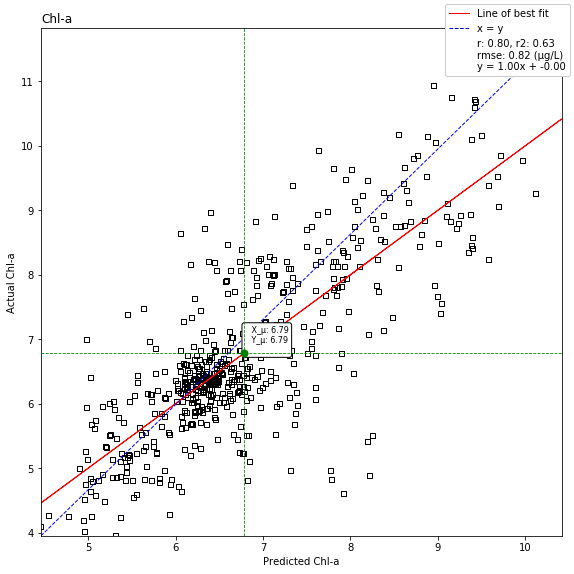

In [44]:
#create scatter plot of predicted vs actual
rsl.make_scatter(prediction,
            y_test,
            '(μg/L)',
            'Chl-a',
            'Predicted Chl-a',
            'Actual Chl-a',
            'Chl-a',
            show_ave = True,
            rmse = True)



    args: X, num_bins, 
    file_name, title, xlabel
          


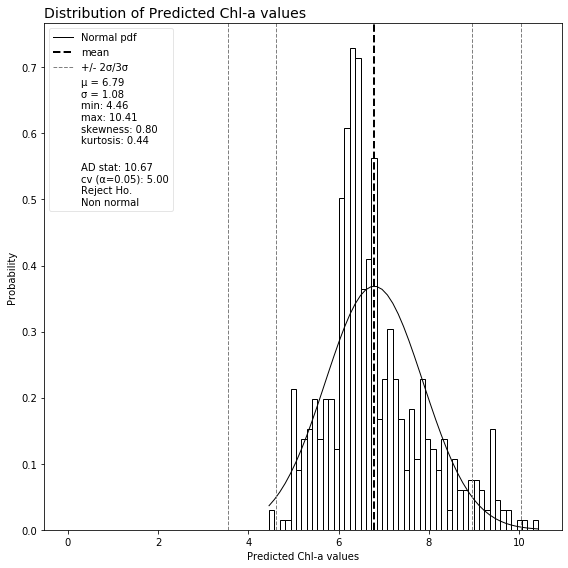

In [45]:
#make histogram of predicted chl-a values
rsl.make_histogram(prediction,
              num_bins = 50,
              file_name = 'predicted',
              title = 'Distribution of Predicted Chl-a values',
              xlabel = 'Predicted Chl-a values')



    args: X, num_bins, 
    file_name, title, xlabel
          


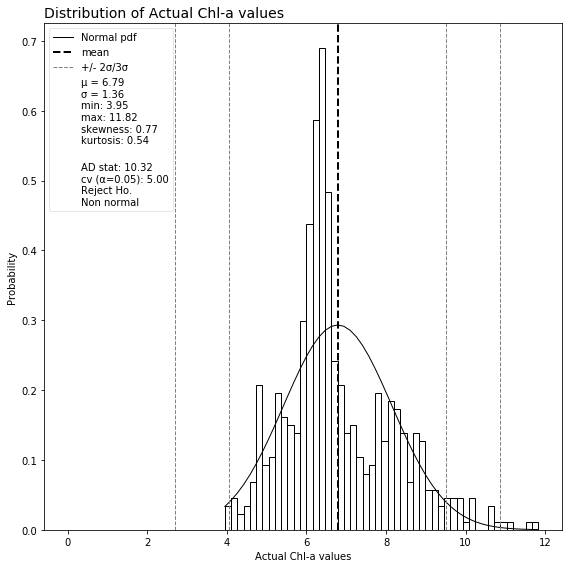

In [46]:
#make histogram of predicted chl-a values
rsl.make_histogram(y_test,
              num_bins = 50,
              file_name = 'actual',
              title = 'Distribution of Actual Chl-a values',
              xlabel = 'Actual Chl-a values')

In [47]:
dct = {'actual': y_test,
      'predicted': prediction}
actual_predicted = pd.DataFrame(dct)


    args: X,
    bins,
    file_name,
    color_list
         

    more color codes in this site
    https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    



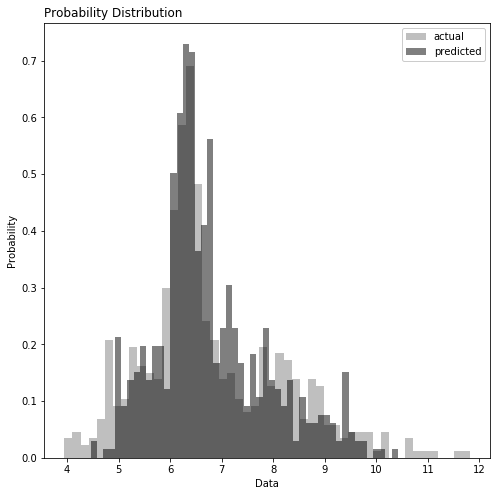

In [48]:
#overlay predicted and actual chl-a values distributions
rsl.make_multiple_histogram(actual_predicted,
                      bins = 50,
                      file_name = 'actual_predicted',
                      color_list = ['grey', 'k'],
                      alpha = 0.5)



    args: X, num_bins, 
    file_name, title, xlabel
          


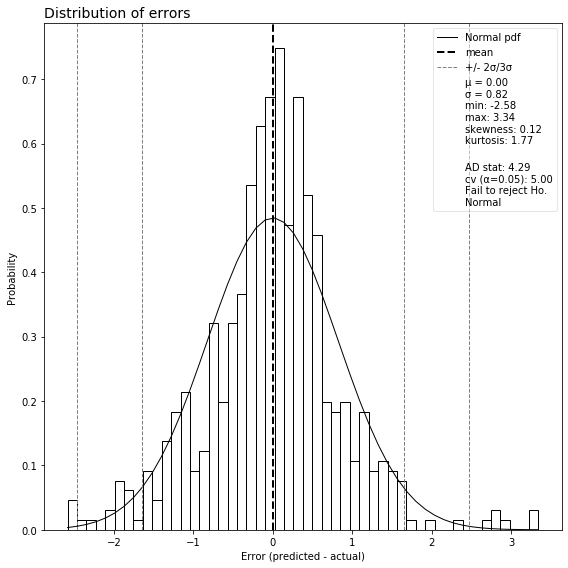

In [49]:
#make histogram of errors
error = prediction - y_test
rsl.make_histogram(error,
              num_bins = 50,
              file_name = 'error',
              title = 'Distribution of errors',
              xlabel = 'Error (predicted - actual)')

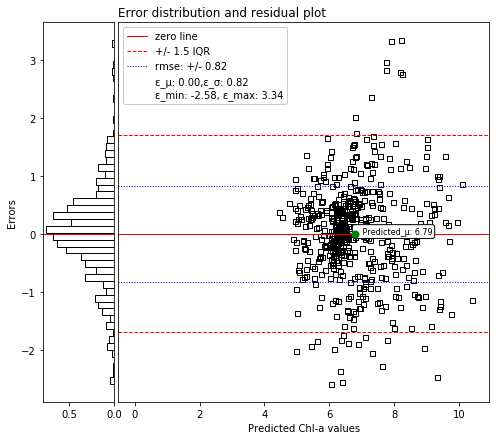

In [50]:
import rs_learn as rsl
rsl.make_residual_plot(y_test,
                  prediction, 
                  bins = 50,
                  file_name = 'error',
                  xlabel = 'Predicted Chl-a values')